# Model with weather, plane and airport variables (cancellation_flag)

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso, LogisticRegression 
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Import flight data, then filter airline

In [2]:
flight_data = pd.read_csv("../../data/clean_data/flight_delay_clean.csv")
flight_data.shape

(303748, 24)

In [3]:
# filter for required airlines
airline_delay_data = flight_data[flight_data['origin'] == "EWR"].copy()
airline_delay_data.reset_index(inplace=True, drop=True)
airline_delay_data.shape

(115968, 24)

In [4]:
airline_delay_data.describe()

,month,wday,hour,flights_per_day,flights_per_hour,dep_delay,distance,nose_dir,seats,wind_dir,wind_speed,visib,prcp,snow,snwd,tavg,pres
count,115968.000000,115968.000000,115968.000000,115968.000000,115968.000000,113067.000000,115968.000000,115968.000000,108168.000000,115968.000000,115968.000000,115968.000000,115968.000000,115968.000000,115968.000000,115968.000000,115968.000000
mean,6.557205,3.924738,13.204453,841.397360,52.099803,18.781599,1136.088895,232.300384,151.229245,181.331057,8.498260,9.353627,0.130145,0.086933,0.184549,56.978891,1017.128838
std,3.405443,1.943472,4.775782,81.327843,12.510210,47.995638,764.571582,62.102255,77.418120,113.728902,4.463096,1.861124,0.389447,0.664194,0.798220,16.898840,6.843647
min,1.000000,1.000000,1.000000,535.000000,2.000000,0.000000,93.000000,7.496324,1.000000,0.000000,0.000000,0.130000,0.000000,0.000000,0.000000,16.000000,995.800000
25%,4.000000,2.000000,9.000000,820.000000,45.000000,0.000000,628.000000,207.829268,91.250000,70.000000,5.753900,10.000000,0.000000,0.000000,0.000000,43.000000,1013.200000
50%,7.000000,4.000000,14.000000,865.000000,54.000000,0.000000,937.000000,244.843285,149.000000,210.000000,8.055460,10.000000,0.000000,0.000000,0.000000,58.000000,1016.200000
75%,9.000000,6.000000,17.000000,899.000000,60.000000,14.000000,1504.000000,278.009949,191.000000,270.000000,11.507800,10.000000,0.040000,0.000000,0.000000,72.000000,1021.300000
max,12.000000,7.000000,23.000000,931.000000,84.000000,1217.000000,4962.000000,329.743683,552.000000,360.000000,26.467940,10.000000,3.860000,7.800000,5.900000,87.000000,1039.100000


In [5]:
# convert outcome flag to numeric data from category
airline_delay_data['cancelled_flag'] = (np.where(airline_delay_data['delay_flag'] == "Cancelled", 1, 0))
list(airline_delay_data)

['sch_departure',
 'month',
 'wday',
 'hour',
 'cycle',
 'flights_per_day',
 'flights_per_hour',
 'origin',
 'dep_delay',
 'delay_flag',
 'dest',
 'distance',
 'nose_dir',
 'carrier',
 'type',
 'seats',
 'wind_dir',
 'wind_speed',
 'visib',
 'prcp',
 'snow',
 'snwd',
 'tavg',
 'pres',
 'cancelled_flag']

# Select required variables

In [6]:
delay_df = airline_delay_data[['cancelled_flag', 'wind_dir', 'wind_speed', 'visib',
                               'prcp', 'snow', 'snwd', 'tavg', 'pres', 
                               'dest', 'distance', 'nose_dir', 'carrier', 'type',
                               'seats', 'month', 'wday', 'hour', 'cycle',
                               'flights_per_day', 'flights_per_hour']].dropna().copy()
delay_df.shape

(108168, 21)

In [7]:
# create dummies if required
delay_df = pd.get_dummies(delay_df, drop_first = True)
delay_df.shape

(108168, 122)

In [8]:
# file paths to save outputs
plot_tree_filename = "saved_models/cancellation_weather_plane_time_decision_tree.png"

## Separate response and scale features

In [9]:
delay_predictors = delay_df.drop(columns = 'cancelled_flag')
delay_response = delay_df['cancelled_flag']

In [10]:
# scale features
ss = StandardScaler()
delay_predictors_scaled = ss.fit_transform(delay_predictors)
delay_predictors = pd.DataFrame(delay_predictors_scaled, columns = delay_predictors.columns)

In [11]:
# delay_predictors.mean()

In [12]:
# delay_predictors.std()

# Model selection

## Balance dataset (undersample)

In [13]:
# check number of outcomes: OnTime vs Delayed
bal_delay_predictors, bal_delay_response = delay_predictors, delay_response.copy()
print(Counter(bal_delay_response))

Counter({0: 106154, 1: 2014})


In [14]:
# undersampling method
under = RandomUnderSampler(sampling_strategy=1)
bal_delay_predictors, bal_delay_response = under.fit_resample(bal_delay_predictors, bal_delay_response)

print(Counter(bal_delay_response))

Counter({0: 2014, 1: 2014})


## Model Tuning

In [15]:
# Define a list of regression models to iterate over
models = [LinearRegression(), LogisticRegression(max_iter=2000), RandomForestClassifier(),
          DecisionTreeClassifier(), RandomForestRegressor(), KNeighborsRegressor(),
          Ridge(), Lasso(), GaussianNB()]

# Initialize variables to keep track of the best model and its score
best_model = None
best_score = 0
    
# Define the cross-validation strategy
cv = KFold(n_splits=10, random_state=42, shuffle=True)

# For each model
for model in models:
    
   # Perform cross-validation and compute the average score
    scores = cross_val_score(model, bal_delay_predictors, bal_delay_response, cv=cv)  # 5-fold cross-validation
    score = scores.mean()
    print(f"Model: {str(model)}, Average cross-validation score = {score}")

    # Check if the current model has a higher score than the best model
    if score > best_score:
        best_model = model
        best_score = score

# Print the best model
print(f"\nBest Model: {best_model} with average cross-validation score = {best_score}")

Model: LinearRegression(), Average cross-validation score = -3.271148807195572e+23
Model: LogisticRegression(max_iter=2000), Average cross-validation score = 0.838388084391936
Model: RandomForestClassifier(), Average cross-validation score = 0.8947446390874413
Model: DecisionTreeClassifier(), Average cross-validation score = 0.8597317383306791
Model: RandomForestRegressor(), Average cross-validation score = 0.6897944009894477
Model: KNeighborsRegressor(), Average cross-validation score = 0.44027060400512286
Model: Ridge(), Average cross-validation score = 0.49375224013360447
Model: Lasso(), Average cross-validation score = -0.0016364901721057645
Model: GaussianNB(), Average cross-validation score = 0.76514943890967

Best Model: RandomForestClassifier() with average cross-validation score = 0.8947446390874413


## RandomForestClassifier parameter tuning

In [16]:
X_train, X_test, y_train, y_test = train_test_split(bal_delay_predictors, bal_delay_response,
                                       test_size=0.25,
                                       random_state=42)
X_train.shape, X_test.shape

((3021, 121), (1007, 121))

### Build Random Forest Model

In [17]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
  
# predict the mode
y_pred = model.predict(X_test)
  
# performance evaluation metrics
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       493
           1       0.91      0.85      0.88       514

    accuracy                           0.88      1007
   macro avg       0.88      0.88      0.88      1007
weighted avg       0.88      0.88      0.88      1007



In [18]:
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}

### Hyperparameter Tuning- GridSearchCV

In [19]:
# find best paramenters
grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9,
                       n_estimators=150)


In [20]:
# update the parameters of the model
model_grid = RandomForestClassifier(max_depth=6,
                                    max_features=None,
                                    max_leaf_nodes=9,
                                    n_estimators=150)

model_grid.fit(X_train, y_train)
y_pred_grid = model.predict(X_test)
print(classification_report(y_pred_grid, y_test))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       493
           1       0.91      0.85      0.88       514

    accuracy                           0.88      1007
   macro avg       0.88      0.88      0.88      1007
weighted avg       0.88      0.88      0.88      1007



### Hyperparameter Tuning- RandomizedSearchCV

In [21]:
# find best paramenters
random_search = RandomizedSearchCV(RandomForestClassifier(),
                                   param_grid)
random_search.fit(X_train, y_train)
print(random_search.best_estimator_)

RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=6,
                       n_estimators=25)


In [22]:
# update the parameters of the model
model_random = RandomForestClassifier(max_depth=9,
                                      max_features=None,
                                      max_leaf_nodes=6,
                                      n_estimators=25)

model_random.fit(X_train, y_train)
y_pred_rand = model.predict(X_test)
print(classification_report(y_pred_rand, y_test))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       493
           1       0.91      0.85      0.88       514

    accuracy                           0.88      1007
   macro avg       0.88      0.88      0.88      1007
weighted avg       0.88      0.88      0.88      1007



# Build model

## Split the data

In [23]:
# create test/train split (80%:20%)
delay_pred_train, delay_pred_test, delay_resp_train, delay_resp_test = (
    train_test_split(
        delay_predictors, 
        delay_response, 
        test_size = 0.2, 
        random_state = 7
    )
)

delay_pred_train.shape, delay_pred_test.shape

((86534, 121), (21634, 121))

In [24]:
# create balanced train set
bal_delay_pred_train, bal_delay_resp_train = delay_pred_train, delay_resp_train.copy()
print(Counter(bal_delay_resp_train))

under = RandomUnderSampler(sampling_strategy=1)
bal_delay_pred_train, bal_delay_resp_train = under.fit_resample(bal_delay_pred_train, bal_delay_resp_train)
print(Counter(bal_delay_resp_train))

Counter({0: 84933, 1: 1601})
Counter({0: 1601, 1: 1601})


## Run the model

In [25]:
# run the model with parameters from grid
model = RandomForestClassifier(max_depth=6,
                               max_features=None,
                               max_leaf_nodes=9,
                               n_estimators=150)

# train the model on the training data
model.fit(bal_delay_pred_train, bal_delay_resp_train)

RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9,
                       n_estimators=150)

In [26]:
accuracy_scores = cross_val_score(
    model, bal_delay_pred_train, bal_delay_resp_train, scoring='accuracy', cv=10
)

np.mean(accuracy_scores)

0.85819996105919

In [27]:
roc_scores = cross_val_score(
    model, bal_delay_pred_train, bal_delay_resp_train, scoring='roc_auc', cv=10
)

np.mean(roc_scores)

0.9268231512034163

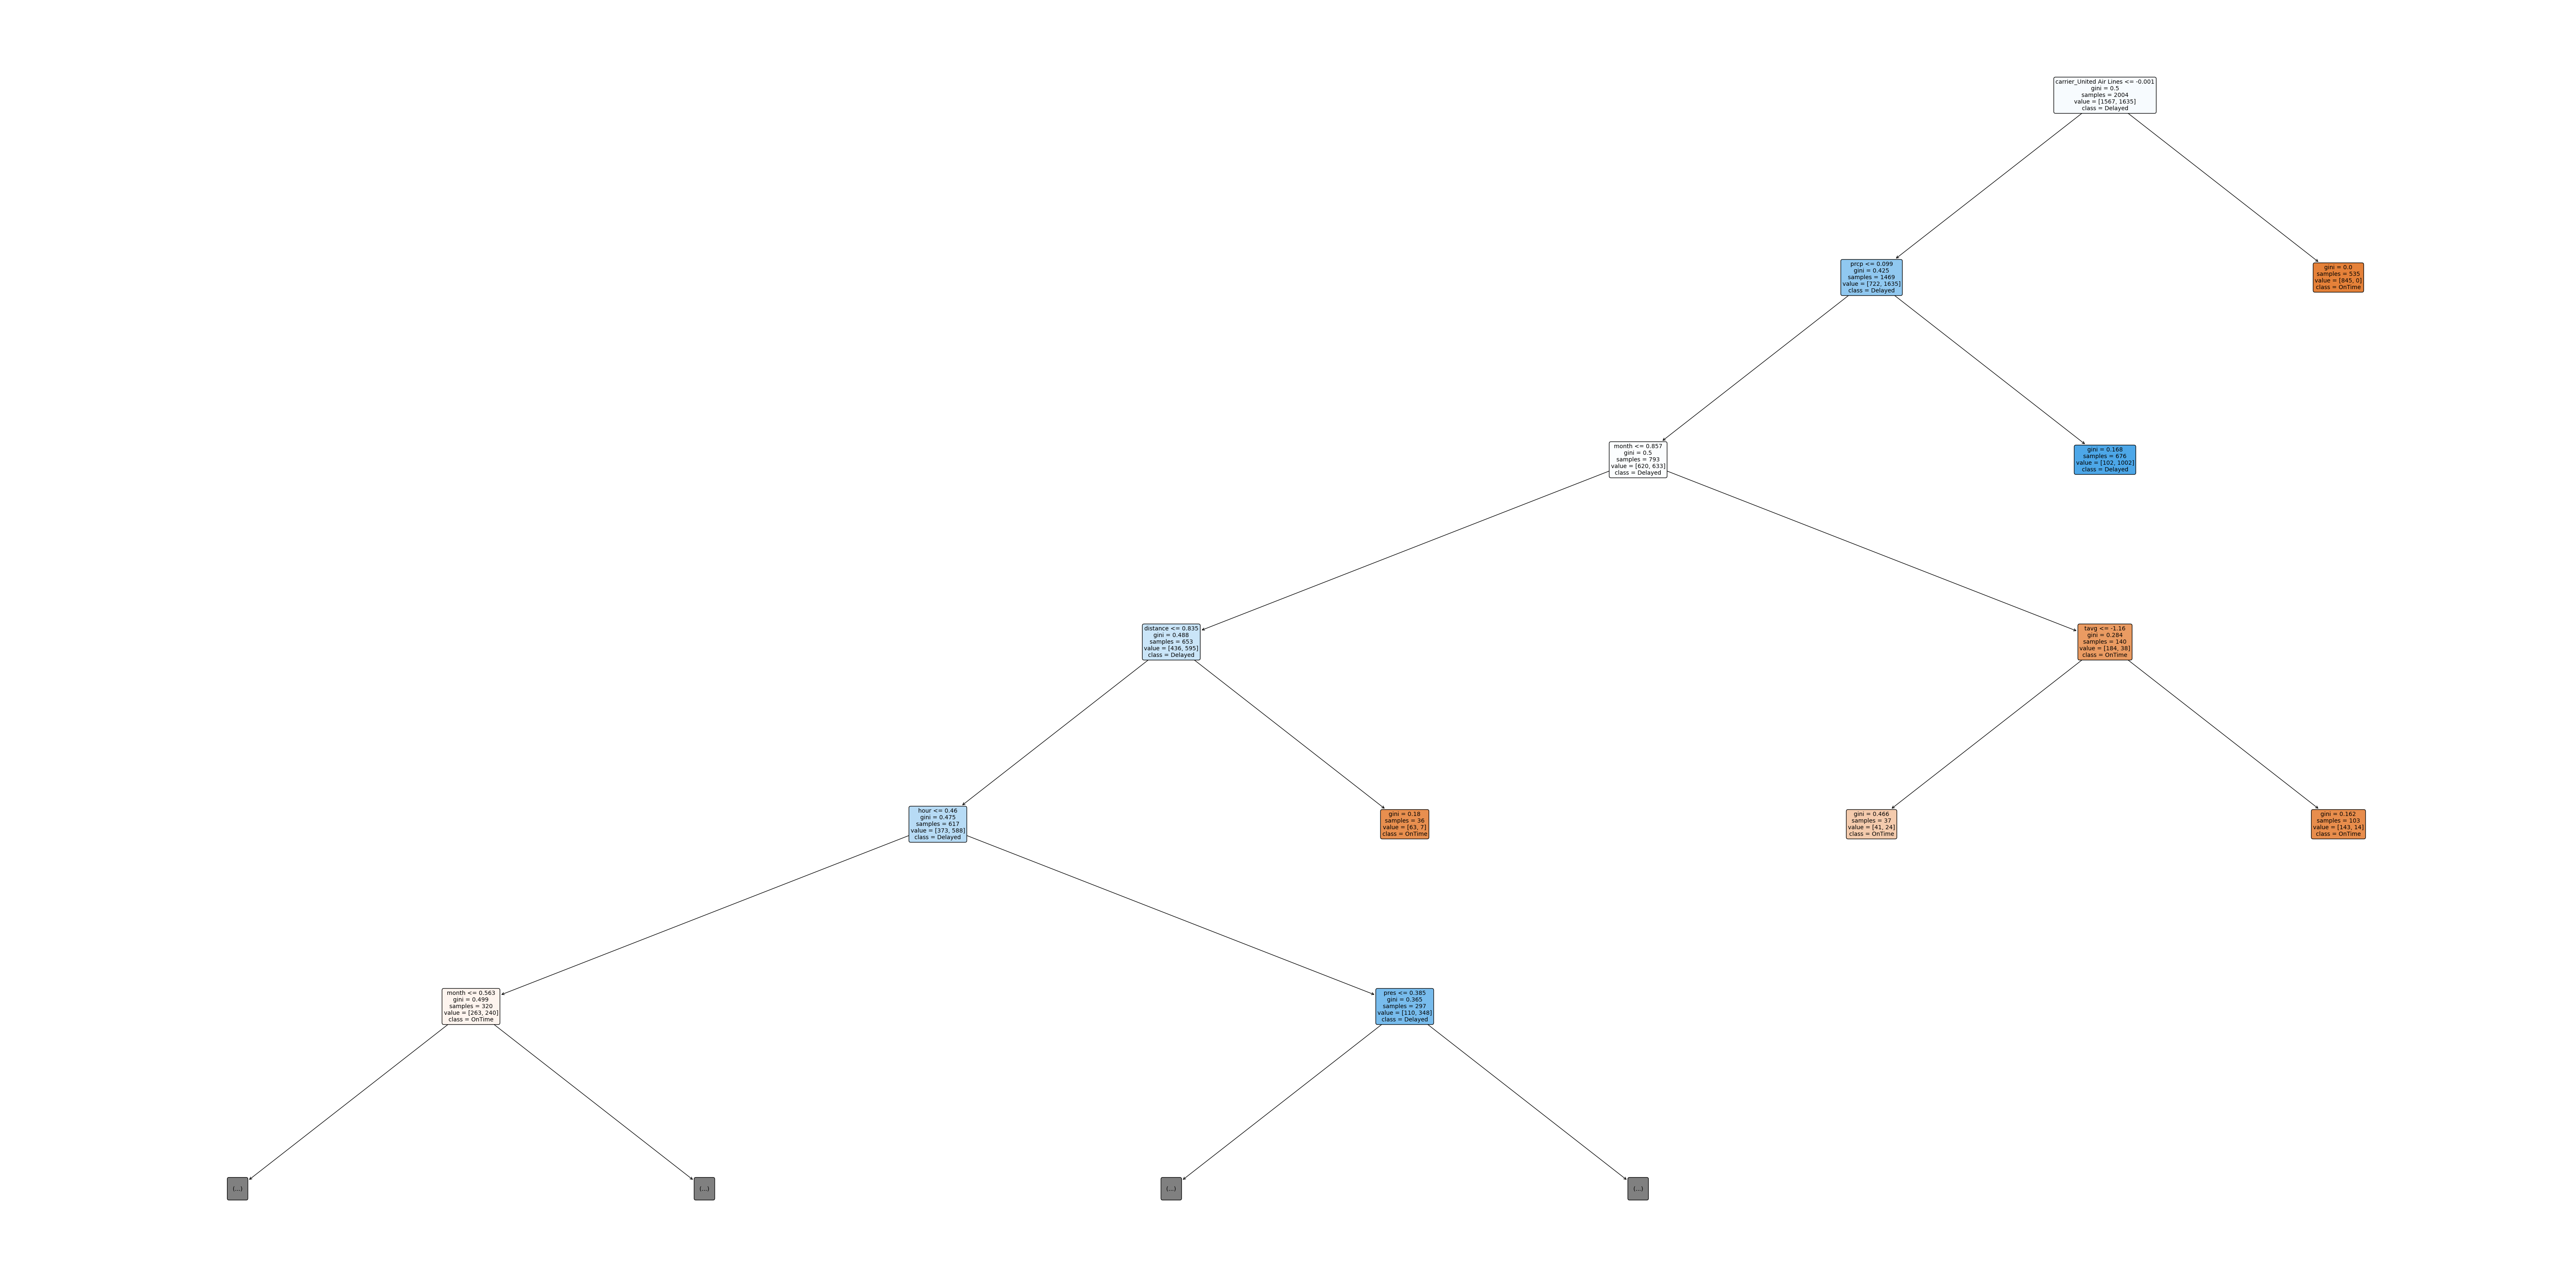

In [28]:
# create a list with names of predictors, and an array with target categories for plotting
delay_pred_names = list(delay_pred_test)
delay_resp_names = ['OnTime', 'Delayed']

# set the figure size
fig = plt.figure(figsize=(80, 40))

# plot the decision tree
plot_tree(model.estimators_[0], # Pull out one tree from the forest
          max_depth = 5,
          feature_names = delay_pred_names,
          class_names = delay_resp_names, 
          filled=True,
          fontsize=10,
          rounded=True)

plt.savefig(plot_tree_filename)
plt.show()

In [29]:
importances = list(model.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature,
                       importance in zip(delay_pred_names, importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:40} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: carrier_United Air Lines                 Importance: 0.63
Variable: prcp                                     Importance: 0.19
Variable: month                                    Importance: 0.05
Variable: hour                                     Importance: 0.05
Variable: distance                                 Importance: 0.03
Variable: snwd                                     Importance: 0.01
Variable: tavg                                     Importance: 0.01
Variable: pres                                     Importance: 0.01
Variable: seats                                    Importance: 0.01
Variable: flights_per_day                          Importance: 0.01
Variable: wind_dir                                 Importance: 0.0
Variable: wind_speed                               Importance: 0.0
Variable: visib                                    Importance: 0.0
Variable: snow                                     Importance: 0.0
Variable: nose_dir                                 I

## Confusion matrix and classification report

In [30]:
# create balanced test set
bal_delay_pred_test, bal_delay_resp_test = delay_pred_test, delay_resp_test.copy()
print(Counter(bal_delay_resp_test))

under = RandomUnderSampler(sampling_strategy=1)
bal_delay_pred_test, bal_delay_resp_test = under.fit_resample(bal_delay_pred_test, bal_delay_resp_test)
print(Counter(bal_delay_resp_test))

Counter({0: 21221, 1: 413})
Counter({0: 413, 1: 413})


In [31]:
y_pred = model.predict(bal_delay_pred_test)

In [32]:
cm = confusion_matrix(bal_delay_resp_test, y_pred)
cm

array([[338,  75],
       [ 44, 369]], dtype=int64)

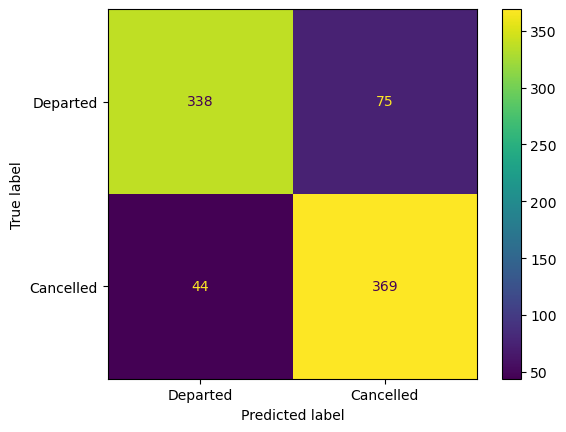

In [35]:
# plot confusion matrix
cm = confusion_matrix(bal_delay_resp_test, y_pred, labels=model.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Departed", "Cancelled"])
disp.plot()
plt.show()

In [36]:
# get classification report
print(classification_report(bal_delay_resp_test, y_pred, target_names=["Departed", "Cancelled"]))

              precision    recall  f1-score   support

    Departed       0.88      0.82      0.85       413
   Cancelled       0.83      0.89      0.86       413

    accuracy                           0.86       826
   macro avg       0.86      0.86      0.86       826
weighted avg       0.86      0.86      0.86       826

